In [1]:
import matplotlib.pyplot as plt
import numpy as np

from numba import float64, int64,  njit
import numba as nb

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error

import time


# Numba implementation

In [5]:
@njit(nb.types.Tuple((float64, float64[:], float64[:]))(float64[:, :], float64[:], 
                                                        float64, float64, int64), 
      parallel=True)
def numba_lasso(X, y, 
                lamb, tol, maxIter):
    X = np.ascontiguousarray(X)
    y = np.ascontiguousarray(y)
    intercept = np.mean(y)
    XY = np.dot(X.T, y - intercept)
    XX = np.dot(X.T, X)
    beta = np.zeros(X.shape[1])  # Initial guess
    losses = np.zeros(maxIter)
       
    for i in range(maxIter):
        maxChange = 0.0
        losses[i] = 0.5 * np.mean(np.square(y - np.dot(X,beta) - intercept)) + lamb * np.sum(np.abs(beta))
        newBeta = XY - np.dot(XX,beta)
        oldBeta = beta.copy()
        for j in range(len(beta)):
            newBeta += XX[:,j]*beta[j]
            beta[j] = np.sign(newBeta[j]) * np.maximum(np.abs(newBeta[j]) - lamb, 0.0) / XX[j,j]
            newBeta -= XX[:,j]*beta[j]
        if np.max(np.abs(beta - oldBeta)) < tol * np.max(np.abs(beta)):
            break
    print("Finished after", i, 'iterations')   
    
    return intercept, beta, losses[:i]
    

class NumbaLasso():
    def __init__(self, lamb = 1.0, tol=1e-4):
        self.lamb = np.abs(lamb)  # lambda regularisation parameter.
        self.tol = tol
        
    def fit(self, X, y, maxIter = 10**4):
        self.intercept, self.beta, self.losses = numba_lasso(X, y,
                                                             self.lamb, 
                                                             self.tol, maxIter)
                    
    def predict(self, X):
        return np.matmul(X, self.beta) + self.intercept

Input shape (100, 500)

SKlearn
It took 6.33e-03 seconds
MSE = 4.22e+02

Numba
Finished after 99 iterations
It took 3.35e-01 seconds
MSE = 4.21e+02


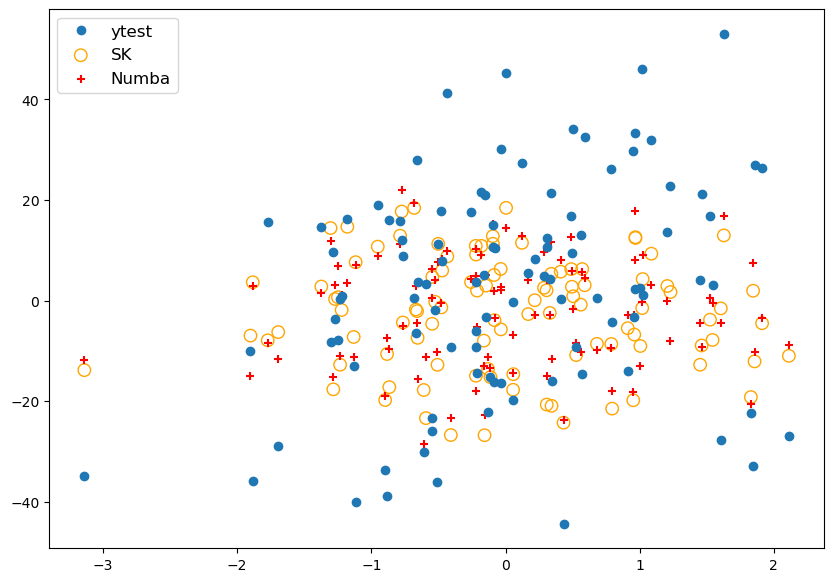

In [10]:
d = 500
N = 100
X = np.random.rand(N,d)
Xtest = np.random.randn(N,d)
eps = 0.01
bias = 1.0
m = np.array([5,-6,3,0.1])
m = np.concatenate((m, np.random.randn(d-len(m))))
y = np.dot(X,m) + np.random.randn(N) * eps + bias
ytest = np.dot(Xtest,m) + np.random.randn(N) * eps + bias
print("Input shape", X.shape)



fig, _ = plt.subplots(figsize=(10,7))
lamb = 0.05
regSK = Lasso(alpha = lamb)
regNumba = NumbaLasso(lamb = N*lamb)

print()
print('SKlearn')
start = time.time()
regSK.fit(X,y)
print("It took {:.2e} seconds".format(time.time() - start))
print('MSE = {:.2e}'.format(mean_squared_error(ytest, regSK.predict(Xtest))))
# print(regSK.coef_)

print()
print('Numba')
start = time.time()
regNumba.fit(X,y, maxIter = 100)
print("It took {:.2e} seconds".format(time.time() - start))
print('MSE = {:.2e}'.format(mean_squared_error(ytest, regNumba.predict(Xtest))))
# print(regNumba.beta)

plt.plot(Xtest[:,0], ytest, 'o', label = 'ytest')
plt.scatter(Xtest[:,0], regSK.predict(Xtest),s=80, facecolors='none', 
            edgecolors='orange', label = 'SK')
# plt.scatter(Xtest[:,0], regNaive.predict(Xtest), marker='+', 
#             color = 'red', label = 'Naive')
plt.scatter(Xtest[:,0], regNumba.predict(Xtest), marker='+', color = 'red', label='Numba')
plt.legend(fontsize = 12)
plt.show()


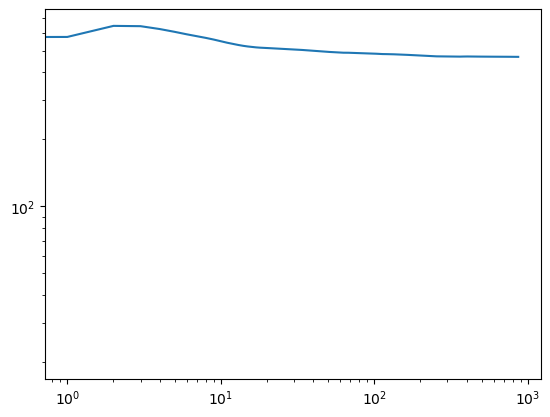

In [15]:
plt.loglog(regNumba.losses)
plt.show()